In [2]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import calendar

from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose


# EDA

## About Data


This dataset provides information on motor vehicle operators (drivers) involved in traffic collisions occurring on county and local roadways. The dataset reports details of all traffic collisions occurring on county and local roadways within Montgomery County, as collected via the Automated Crash Reporting System (ACRS) of the Maryland State Police, and reported by the Montgomery County Police, Gaithersburg Police, Rockville Police, or the Maryland-National Capital Park Police. This dataset shows each collision data recorded and the drivers involved.



## Data Overview

In [3]:
DB_PATH = "data/data.duckdb"

conn = duckdb.connect(database=DB_PATH, read_only=False)

In [4]:
conn.sql("SHOW TABLES;")

┌──────────────┐
│     name     │
│   varchar    │
├──────────────┤
│ drivers      │
│ incidents    │
│ non_motorist │
└──────────────┘

In [5]:
conn.sql("SELECT * FROM drivers LIMIT 3;").fetchdf()

,report_number,local_case_number,agency_name,acrs_report_type,crash_datetime,route_type,road_name,cross-street_name,off-road_description,municipality,...,speed_limit,driverless_vehicle,parked_vehicle,vehicle_year,vehicle_make,vehicle_model,latitude,longitude,location,vehicle_type_group
0,DM8479000T,210020119.0,Takoma Park Police Depart,Property Damage Crash,2021-05-27 19:40:00,None,None,None,IN PARKING LOT,None,...,0,No,True,2017,HINO,TWK,38.987657,-76.987545,"(38.98765667, -76.987545)",None
1,MCP2970000R,15045937.0,MONTGOMERY,Property Damage Crash,2015-09-11 13:29:00,None,None,None,Parking Lot: \n2525 Ennalls Ave,None,...,5,No,False,2012,TOYOTA,SU,39.039917,-77.053649,"(39.03991652, -77.05364898)",Passenger Vehicles
2,MCP20160036,180040948.0,Montgomery County Police,Property Damage Crash,2018-08-17 14:25:00,None,None,None,PARKING LOT OF 16246 FREDERICK RD,None,...,15,No,False,2015,MAZD,TK,38.743373,-77.546997,"(38.743373, -77.54699707)",Passenger Vehicles


In [6]:
conn.sql("SELECT * FROM incidents LIMIT 3;").fetchdf()

,report_number,crash_datetime,hit,lane_direction,lane_type,number_of_lanes,direction,distance,road_grade,at_fault,first_harmful_event,second_harmful_event,junction,intersection_type,road_alignment,road_condition,road_division,distance_meters
0,MCP1123002M,2019-03-04 08:41:00,No,[West],None,2,EAST,200.0,GRADE DOWNHILL,DRIVER,OTHER VEHICLE,None,NON INTERSECTION,None,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",60.960
1,MCP21610009,2016-06-04 19:14:00,Yes,[East],None,1,EAST,500.0,LEVEL,DRIVER,PARKED VEHICLE,OTHER VEHICLE,NON INTERSECTION,None,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",152.400
2,MCP2790000P,2015-08-18 23:00:00,No,[South],None,2,SOUTH,30.0,LEVEL,UNKNOWN,PARKED VEHICLE,None,NON INTERSECTION,None,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",9.144


In [7]:
conn.sql("SELECT * FROM non_motorist LIMIT 3;").fetchdf()

,report_number,crash_date/time,person_id,pedestrian_type,pedestrian_movement,pedestrian_actions,pedestrian_location,at_fault,injury_severity,safety_equipment,pedestrian_category,is_helmet_present,is_lighting_present,is_reflective_wear
0,MCP9419004R,08/29/2023 02:00:00 PM,EEB1D2F0-0139-453B-8321-D30FC01D3FB7,OTHER,Other,OTHER,INSIDE BUILDING,No,POSSIBLE INJURY,NONE,OTHER,0.0,0.0,0.0
1,MCP3353001Z,11/30/2023 04:19:00 PM,2259BC33-1276-46BF-A263-15A1B7E079E5,PEDESTRIAN,Standing,NO IMPROPER ACTIONS,OTHER,No,POSSIBLE INJURY,None,PEDESTRIAN,NaN,NaN,NaN
2,MCP30750041,10/21/2023 10:34:00 PM,741BDE7D-D991-4C8D-9909-A400AD8C6B8C,OTHER,Other,OTHER,OTHER,Yes,SUSPECTED MINOR INJURY,None,OTHER,NaN,NaN,NaN


In [8]:
incidents_df = conn.sql("SELECT * FROM incidents;").fetchdf()
drivers_df = conn.sql("SELECT * FROM drivers").fetchdf()
nonmotorist_df = conn.sql("SELECT * FROM non_motorist").fetchdf()

In [9]:
incidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106601 entries, 0 to 106600
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   report_number         106601 non-null  object 
 1   crash_datetime        106601 non-null  object 
 2   hit                   104906 non-null  object 
 3   lane_direction        93146 non-null   object 
 4   lane_type             17547 non-null   object 
 5   number_of_lanes       94261 non-null   object 
 6   direction             93158 non-null   object 
 7   distance              95021 non-null   float64
 8   road_grade            92530 non-null   object 
 9   at_fault              106601 non-null  object 
 10  first_harmful_event   105951 non-null  object 
 11  second_harmful_event  27871 non-null   object 
 12  junction              79122 non-null   object 
 13  intersection_type     50974 non-null   object 
 14  road_alignment        92748 non-null   object 
 15  

In [10]:
drivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188090 entries, 0 to 188089
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   report_number                  188090 non-null  object        
 1   local_case_number              188070 non-null  float64       
 2   agency_name                    188090 non-null  object        
 3   acrs_report_type               188090 non-null  object        
 4   crash_datetime                 188090 non-null  datetime64[ns]
 5   route_type                     169696 non-null  object        
 6   road_name                      168741 non-null  object        
 7   cross-street_name              162133 non-null  object        
 8   off-road_description           17356 non-null   object        
 9   municipality                   19126 non-null   object        
 10  related_non-motorist           6040 non-null    object        
 11  

In [11]:
nonmotorist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6250 entries, 0 to 6249
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   report_number        6250 non-null   object 
 1   crash_date/time      6250 non-null   object 
 2   person_id            6250 non-null   object 
 3   pedestrian_type      6250 non-null   object 
 4   pedestrian_movement  6080 non-null   object 
 5   pedestrian_actions   5956 non-null   object 
 6   pedestrian_location  6097 non-null   object 
 7   at_fault             5963 non-null   object 
 8   injury_severity      6250 non-null   object 
 9   safety_equipment     3839 non-null   object 
 10  pedestrian_category  6250 non-null   object 
 11  is_helmet_present    3839 non-null   float64
 12  is_lighting_present  3839 non-null   float64
 13  is_reflective_wear   3839 non-null   float64
dtypes: float64(3), object(11)
memory usage: 683.7+ KB


### Missing Values

In [12]:
def plot_non_null_percentage(non_null_counts, total_rows, color='blue', title="Non null percentage"):
  
    # Calculate percentage of non-null values
    non_null_percentage = (non_null_counts / total_rows) * 100

    # Prepare data for plotting
    data = non_null_percentage.reset_index()
    data.columns = ['Column', 'Non-Null Percentage']

    # Plot
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(data=data, x='Column', y='Non-Null Percentage', color=color, alpha=0.6)

    # Annotate bars with percentages
    for bar, percentage in zip(barplot.patches, non_null_percentage):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate of the bar's center
            bar.get_height(),                 # Y-coordinate at the top of the bar
            f'{percentage:.1f}%',             # Text to display (formatted percentage)
            ha='center',                      # Horizontal alignment
            va='bottom',                      # Vertical alignment
            fontsize=10,                      # Font size
            color='black'                     # Font color
        )

    # Add labels and title
    plt.title(title, fontsize=16)
    plt.xlabel('Columns', fontsize=14)
    plt.ylabel('Non-Null Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.ylim(0, 105)  # Set a slightly higher Y-axis limit for better visibility of annotations
    plt.tight_layout()
    plt.show()


In [13]:
incidents_nonnull_counts = incidents_df.count()
drivers_nonnull_counts = drivers_df.count()
nonmotorist_nonnull_counts = nonmotorist_df.count()


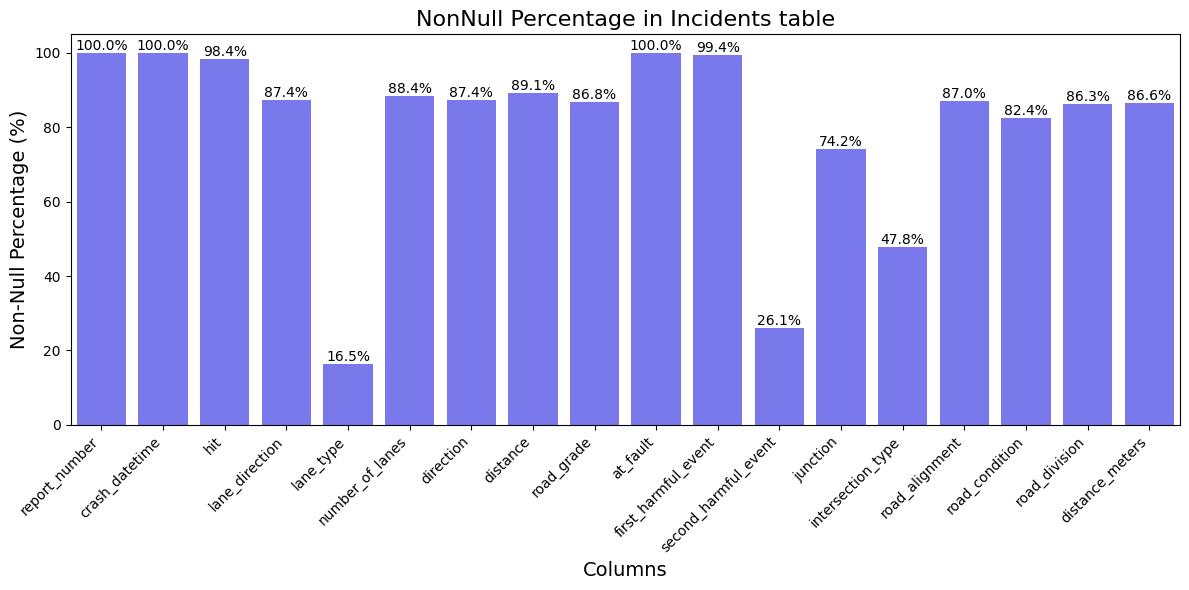

In [14]:
plot_non_null_percentage(incidents_nonnull_counts, len(incidents_df), title="NonNull Percentage in Incidents table")

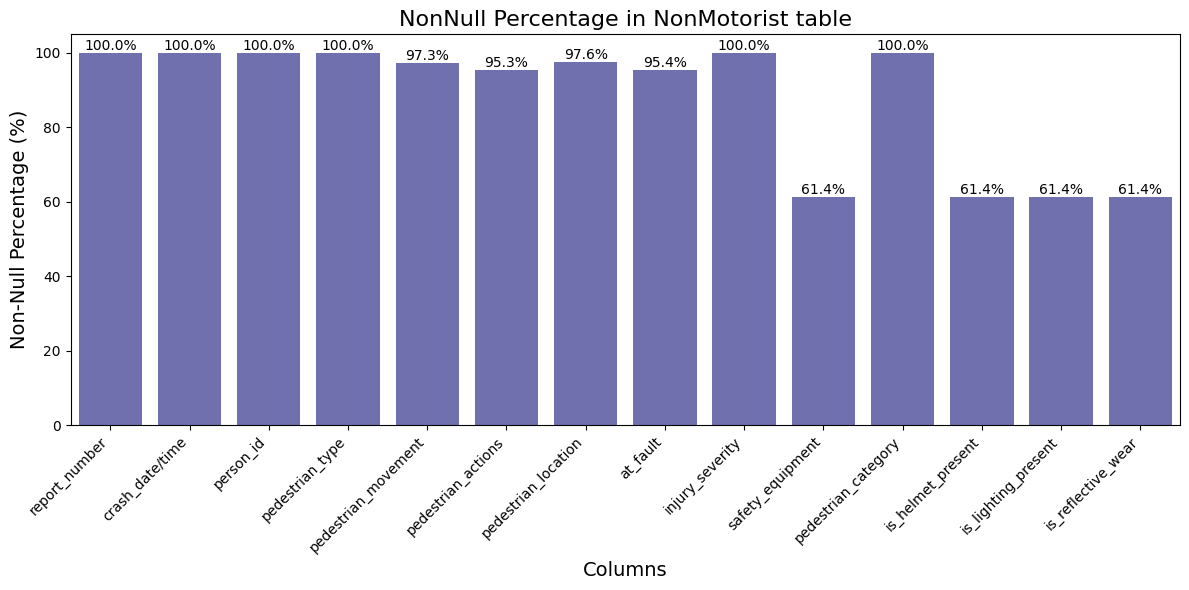

In [15]:
plot_non_null_percentage(nonmotorist_nonnull_counts, len(nonmotorist_df),
                         color="darkblue", title="NonNull Percentage in NonMotorist table")

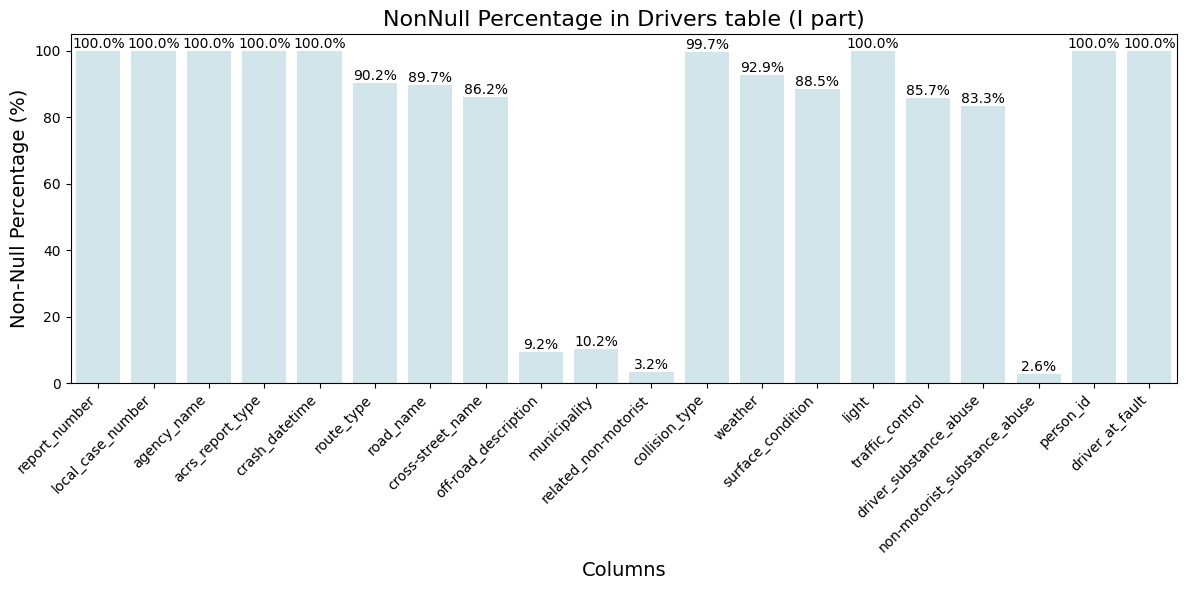

In [16]:
drivers_nonnull_counts_1st = drivers_nonnull_counts[:20]
drivers_nonnull_counts_2nd = drivers_nonnull_counts[20:]


plot_non_null_percentage(drivers_nonnull_counts_1st, len(drivers_df), color="lightblue", title="NonNull Percentage in Drivers table (I part)")

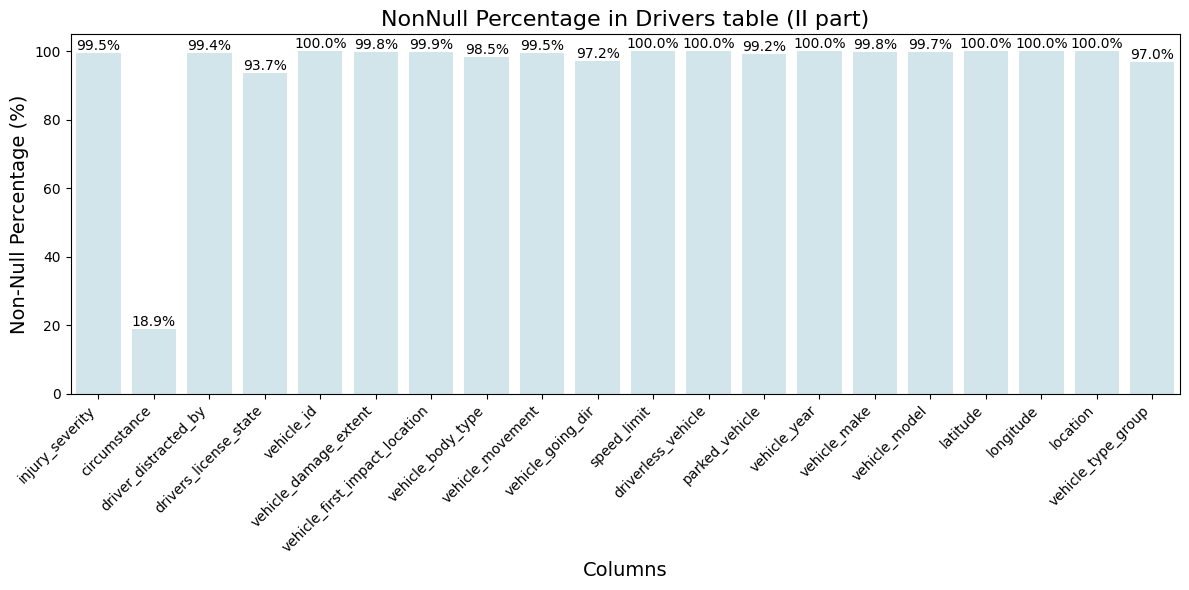

In [17]:
plot_non_null_percentage(drivers_nonnull_counts_2nd, len(drivers_df), color="lightblue", title="NonNull Percentage in Drivers table (II part)")

### Time-Series Analysis: Number of Collisions by Month

#### Related questions

**This section is dedicated to answer these questions:**


1. **Do collisions happen more in winter than in summer?**
2. **What month/season has the highest death rate in collisions?**
3. **Do the average number of collisions tend to decrease or increase year by year?**
4. **Is there seasonality in the number of collisions and death rates?**
5. **What day of the week has the highest number of collisions?**
6. **What time of day do collisions most frequently occur?**
7. **What time of day has the highest rate of serious injuries?**


#### Group number of collisions by month

In [18]:
collision_grouped_by_month = conn.sql("""
    SELECT 
        strftime(CAST(crash_datetime AS TIMESTAMP), '%Y') AS year,
        strftime(CAST(crash_datetime AS TIMESTAMP), '%m') AS month,
        COUNT(*) AS number_of_collisions
    FROM incidents
    WHERE CAST(crash_datetime AS TIMESTAMP) <= TIMESTAMP '2024-10-01'
    GROUP BY year, month
    ORDER BY year, month;
""").fetchdf()


collision_grouped_by_month["date"] = pd.to_datetime(collision_grouped_by_month['year'].astype(str) + '-' + collision_grouped_by_month['month'])
collision_grouped_by_month['quarter'] = collision_grouped_by_month['date'].dt.to_period('Q').astype(str)
collision_grouped_by_quarter = collision_grouped_by_month.groupby('quarter', as_index=False)['number_of_collisions'].sum()
collision_grouped_by_year = collision_grouped_by_month.groupby('year', as_index=False)['number_of_collisions'].sum()

#### Plot collisions by month and by year

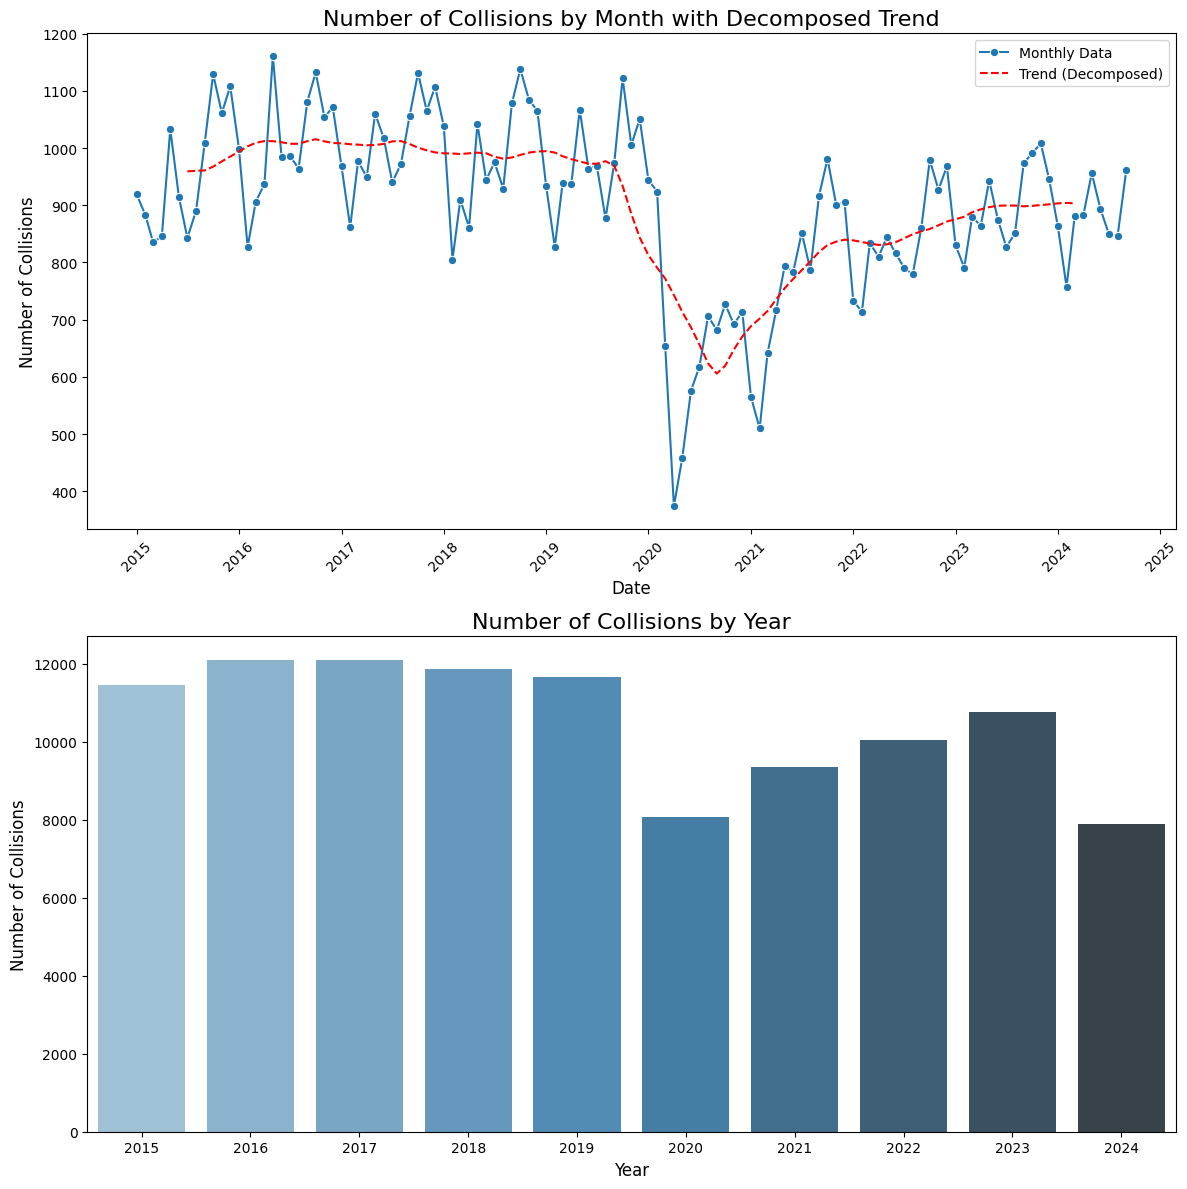

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the data is time-indexed for decomposition
collision_grouped_by_month.set_index('date', inplace=True)

# Perform decomposition (assumes monthly data with a period of 12)
decomposition = seasonal_decompose(collision_grouped_by_month['number_of_collisions'], model='additive', period=12)

# Extract the trend component
trend = decomposition.trend

# Reset index for plotting
collision_grouped_by_month.reset_index(inplace=True)

# Create the figure and axes for two stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# Top plot: Monthly data with trend from decomposition
sns.lineplot(data=collision_grouped_by_month, x='date', y='number_of_collisions', marker='o', ax=axes[0], label='Monthly Data')
axes[0].plot(collision_grouped_by_month['date'], trend, color='red', label='Trend (Decomposed)', linestyle='--')
axes[0].set_title('Number of Collisions by Month with Decomposed Trend', fontsize=16)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Collisions', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Bottom plot: Collisions by year
sns.barplot(data=collision_grouped_by_year, x='year', y='number_of_collisions', palette='Blues_d', ax=axes[1])
axes[1].set_title('Number of Collisions by Year', fontsize=16)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Number of Collisions', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


#### Montly seasonality

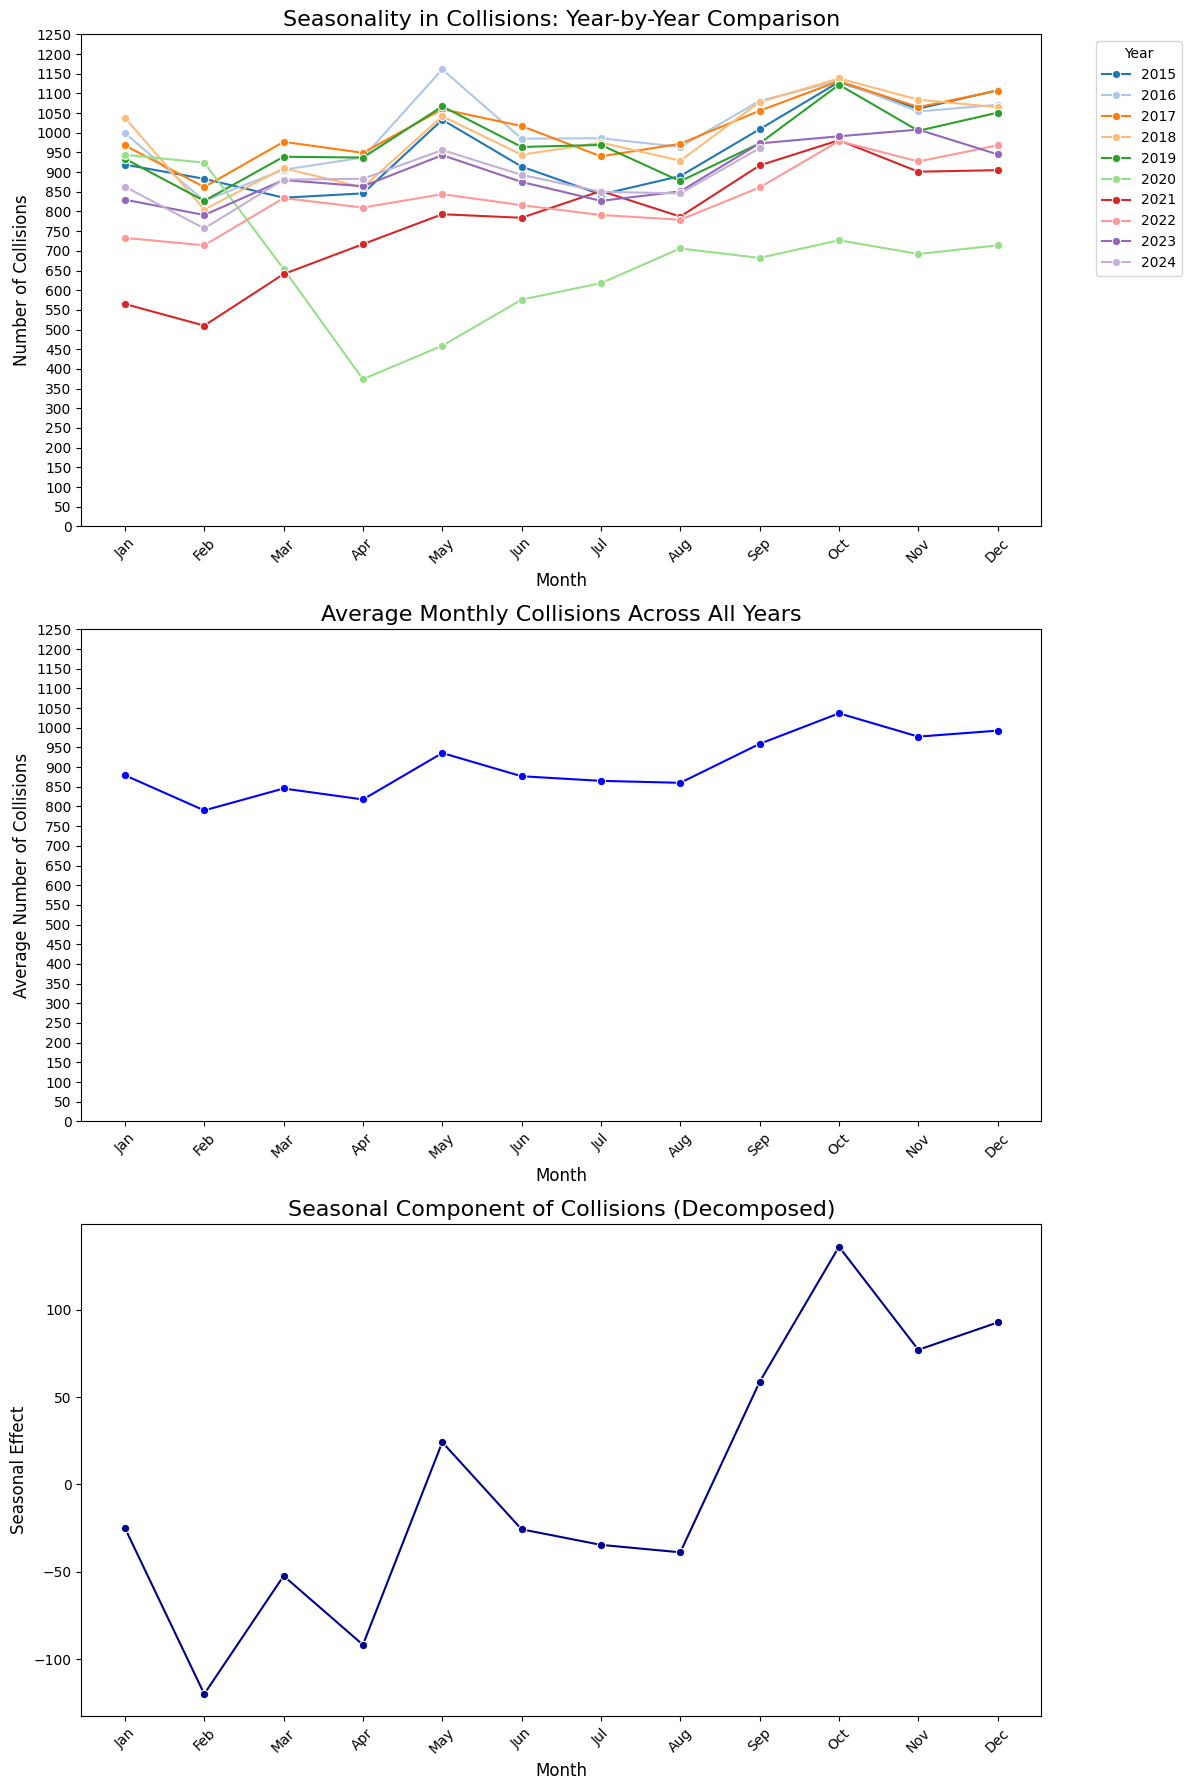

In [20]:
# Ensure the data is time-indexed for decomposition
collision_grouped_by_month.set_index('date', inplace=True)

# Perform decomposition (assuming monthly data with a period of 12)
decomposition = seasonal_decompose(collision_grouped_by_month['number_of_collisions'], model='additive', period=12)

# Extract the seasonal component
seasonality = decomposition.seasonal

# Reset index for compatibility with seaborn
collision_grouped_by_month.reset_index(inplace=True)

# Add month names to the collision data
collision_grouped_by_month['month_name'] = collision_grouped_by_month['date'].dt.strftime('%b')

# Calculate average collisions for each month
average_collisions_by_month = collision_grouped_by_month.groupby('month_name', as_index=False)['number_of_collisions'].mean()
average_collisions_by_month['month_order'] = average_collisions_by_month['month_name'].map(lambda x: list(calendar.month_abbr).index(x))
average_collisions_by_month = average_collisions_by_month.sort_values('month_order')

# Prepare the seasonal component for plotting
seasonal_df = seasonality.reset_index()
seasonal_df['month_name'] = seasonal_df['date'].dt.strftime('%b')
seasonal_df = seasonal_df.groupby('month_name', as_index=False)['seasonal'].mean()
seasonal_df['month_order'] = seasonal_df['month_name'].map(lambda x: list(calendar.month_abbr).index(x))
seasonal_df = seasonal_df.sort_values('month_order')

# Create the figure and axes for three stacked plots
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False)

# Define y-ticks for more granularity
y_ticks = np.arange(0, 1300, 50)

# Top plot: Year-by-year trends
sns.lineplot(
    data=collision_grouped_by_month, 
    x='month_name', 
    y='number_of_collisions', 
    hue='year', 
    marker='o', 
    palette='tab20', 
    ax=axes[0]
)
axes[0].set_title('Seasonality in Collisions: Year-by-Year Comparison', fontsize=16)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Number of Collisions', fontsize=12)
axes[0].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1200)
axes[0].set_yticks(y_ticks)

# Middle plot: Averaged-out year
sns.lineplot(
    data=average_collisions_by_month, 
    x='month_name', 
    y='number_of_collisions', 
    marker='o', 
    color='blue', 
    ax=axes[1]
)
axes[1].set_title('Average Monthly Collisions Across All Years', fontsize=16)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Average Number of Collisions', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0, 1200)
axes[1].set_yticks(y_ticks)

# Bottom plot: Seasonal component from decomposition
sns.lineplot(
    data=seasonal_df, 
    x='month_name', 
    y='seasonal', 
    marker='o', 
    color='darkblue', 
    ax=axes[2]
)
axes[2].set_title('Seasonal Component of Collisions (Decomposed)', fontsize=16)
axes[2].set_xlabel('Month', fontsize=12)
axes[2].set_ylabel('Seasonal Effect', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


#### Heatmap: yearly collisions by month

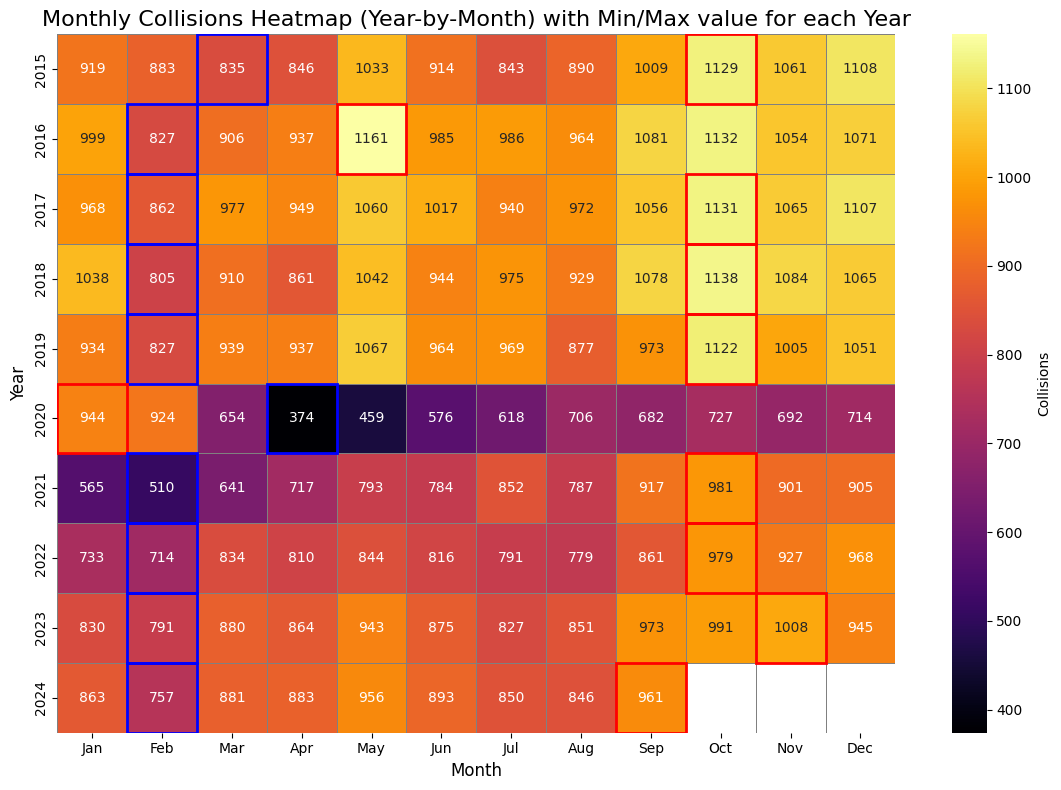

In [21]:
collision_grouped_by_month['month_name'] = collision_grouped_by_month['month'].astype(int).map(lambda x: calendar.month_abbr[x])

# Create a pivot table for heatmap visualization with month names
heatmap_data = collision_grouped_by_month.pivot(index='year', columns='month_name', values='number_of_collisions')

# Ensure columns are sorted by correct month order
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']
heatmap_data = heatmap_data[month_order]  # Reorder columns based on month order

# Create masks for min and max values
min_mask = heatmap_data.eq(heatmap_data.min(axis=1), axis=0)
max_mask = heatmap_data.eq(heatmap_data.max(axis=1), axis=0)

# Plot the base heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    cmap='inferno', 
    annot=True, 
    fmt='.0f', 
    cbar_kws={'label': 'Collisions'}, 
    linewidths=0.5,
    linecolor='gray',
    square=True
)

# Add borders for min and max values
for i in range(heatmap_data.shape[0]):  # Iterate over rows (years)
    for j in range(heatmap_data.shape[1]):  # Iterate over columns (months)
        if min_mask.iloc[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='blue', lw=2))
        elif max_mask.iloc[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

# Add title and labels
plt.title('Monthly Collisions Heatmap (Year-by-Month) with Min/Max value for each Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

In [22]:
num_of_collisions_by_day = conn.sql("""
    SELECT 
    strftime(CAST(crash_datetime AS TIMESTAMP), '%w') as weekday,
    COUNT(*) as number_of_collisions
    FROM incidents GROUP BY weekday ORDER BY weekday;
    
""").fetchdf()


num_of_collisions_by_day['weekday_name'] = num_of_collisions_by_day['weekday'].astype(int).map(lambda x: calendar.day_abbr[x])

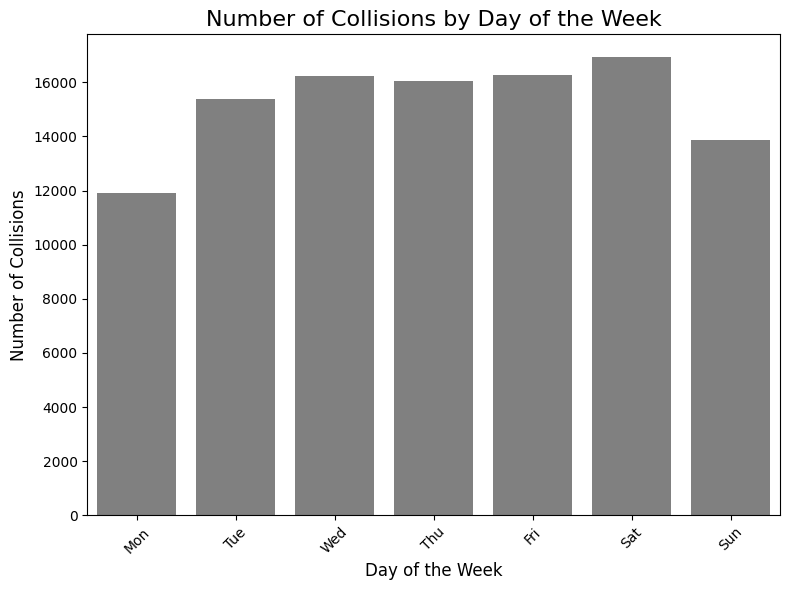

In [23]:
weekday_order = list(calendar.day_abbr)  # ['Sun', 'Mon', 'Tue', ..., 'Sat']
num_of_collisions_by_day['weekday_order'] = num_of_collisions_by_day['weekday_name'].map(lambda x: weekday_order.index(x))
num_of_collisions_by_day = num_of_collisions_by_day.sort_values('weekday_order')

# Plot the barplot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=num_of_collisions_by_day,
    x='weekday_name',
    y='number_of_collisions',
    color='gray'  # Chosen palette for a fresh look
)
plt.title('Number of Collisions by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Collisions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
collisions_by_hour = conn.sql("""
SELECT 
    strftime(CAST(crash_datetime AS TIMESTAMP), '%H')  AS hour, 
    COUNT(*) AS collisions
FROM incidents
GROUP BY hour
ORDER BY hour;
""").fetchdf()



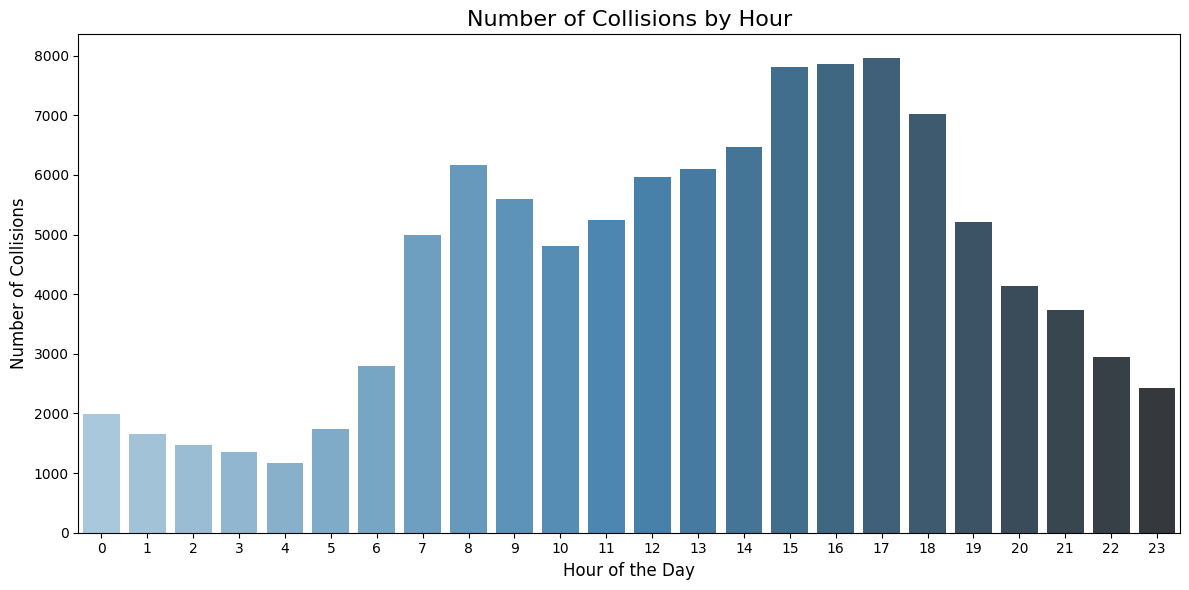

In [25]:
collisions_by_hour["hour"] = collisions_by_hour["hour"].astype(int)
collisions_by_hour = collisions_by_hour.sort_values("hour")

# Plot the barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=collisions_by_hour, x="hour", y="collisions", palette="Blues_d")

# Add title and labels
plt.title("Number of Collisions by Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Number of Collisions", fontsize=12)
plt.xticks(ticks=range(0, 24), labels=range(0, 24))  # Set hour ticks
plt.tight_layout()
plt.show()

#### Collisions with Serious Injuries/Fatal Cases

##### Definition of Serious-Injury Collision

A **serious collision** is defined as an incident where either a driver or a non-motorist (e.g., pedestrian, cyclist) sustains a **fatal injury** or a **suspected serious injury** requiring hospitalization. Data is derived from collision reports in the `incidents`, `drivers`, and `non_motorist` tables, focusing on injury severities classified as `'FATAL INJURY'` or `'SUSPECTED SERIOUS INJURY'`. Identifying serious collisions is crucial for traffic safety analysis, policy development, and effective resource allocation to reduce severe road incidents and improve emergency responses.

In [26]:
serious_collision_grouped_by_month = conn.sql("""
    SELECT 
        strftime(CAST(I.crash_datetime AS TIMESTAMP), '%Y') AS year,
        strftime(CAST(I.crash_datetime AS TIMESTAMP), '%m') AS month,
        COUNT(*) AS number_of_collisions
    FROM incidents I 
    LEFT JOIN drivers D ON I.report_number = D.report_number 
    LEFT JOIN non_motorist NM ON I.report_number = NM.report_number
    WHERE CAST(I.crash_datetime AS TIMESTAMP) <= TIMESTAMP '2024-10-01' 
    AND (
        D.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
        OR NM.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY')
    )
    GROUP BY year, month
    ORDER BY year, month;
""").fetchdf()


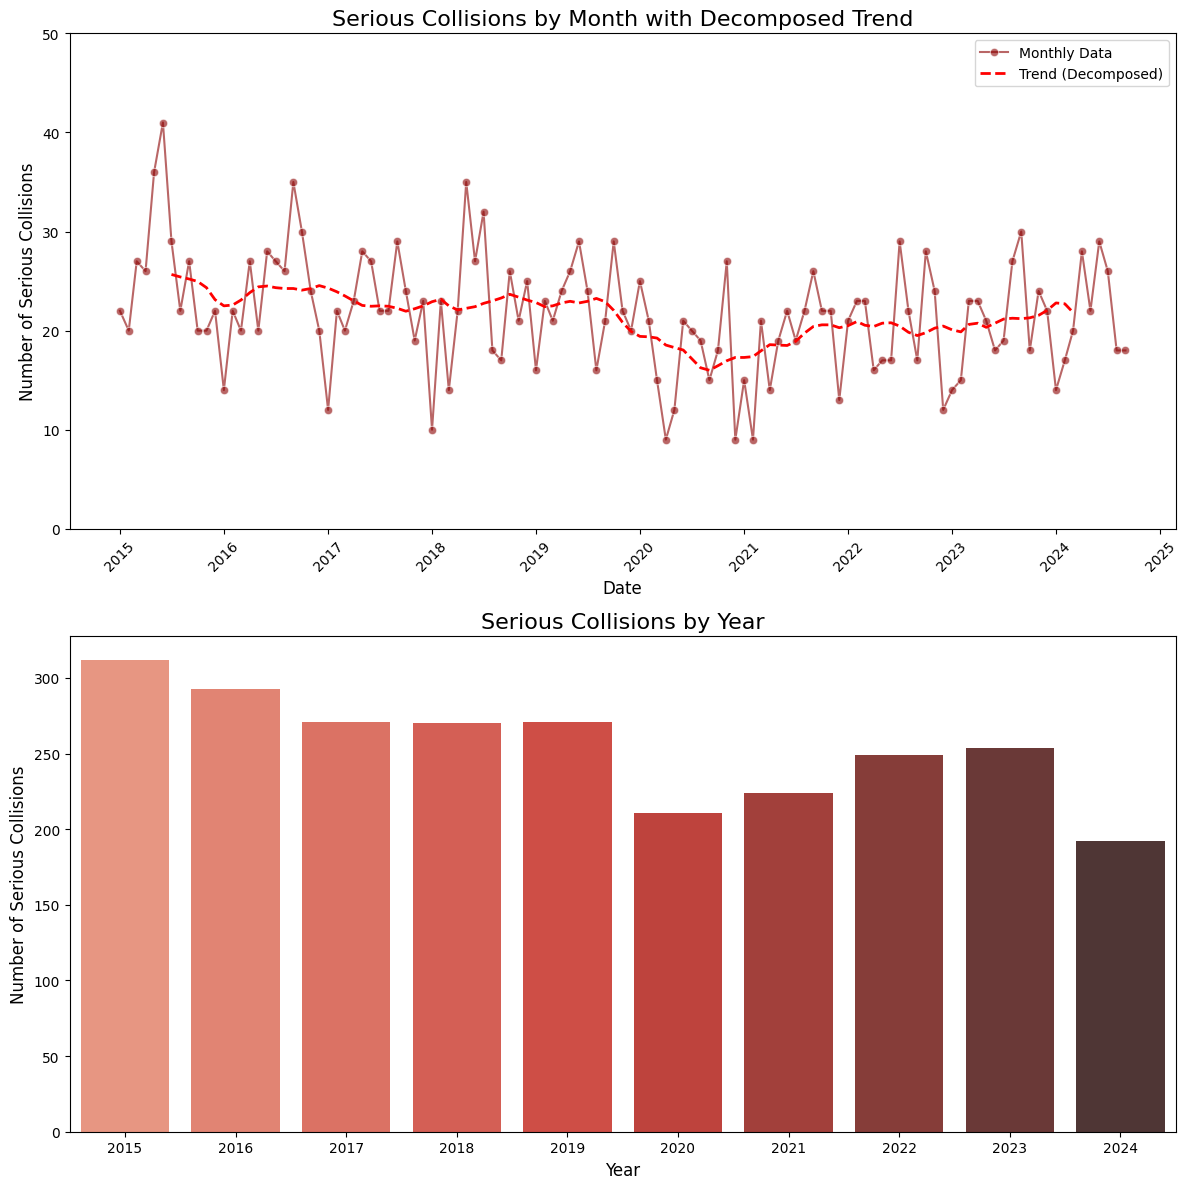

In [28]:
serious_collision_grouped_by_month['date'] = pd.to_datetime(
    serious_collision_grouped_by_month['year'].astype(str) + '-' + serious_collision_grouped_by_month['month']
)

# Ensure the data is time-indexed for decomposition
serious_collision_grouped_by_month.set_index('date', inplace=True)

# Perform decomposition (assumes monthly data with a period of 12)
decomposition = seasonal_decompose(serious_collision_grouped_by_month['number_of_collisions'], model='additive', period=12)

# Extract the trend component
trend = decomposition.trend

# Reset index for compatibility with seaborn
serious_collision_grouped_by_month.reset_index(inplace=True)

# Aggregate serious collisions by year
serious_collision_grouped_by_year = (
    serious_collision_grouped_by_month.groupby('year', as_index=False)['number_of_collisions'].sum()
)

# Create the figure and axes for two stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# Top plot: Monthly data with trend from decomposition
sns.lineplot(
    data=serious_collision_grouped_by_month, 
    x='date', 
    y='number_of_collisions', 
    marker='o', 
    ax=axes[0], 
    label='Monthly Data',
    color="darkred",
    alpha=0.6
)
axes[0].plot(
    serious_collision_grouped_by_month['date'], 
    trend, 
    color='red', 
    label='Trend (Decomposed)', 
    linestyle='--', 
    linewidth=2
)
axes[0].set_title('Serious Collisions by Month with Decomposed Trend', fontsize=16)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Serious Collisions', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 50)
axes[0].legend()

# Bottom plot: Serious collisions by year
sns.barplot(
    data=serious_collision_grouped_by_year, 
    x='year', 
    y='number_of_collisions', 
    palette='Reds_d', 
    ax=axes[1]
)
axes[1].set_title('Serious Collisions by Year', fontsize=16)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Number of Serious Collisions', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

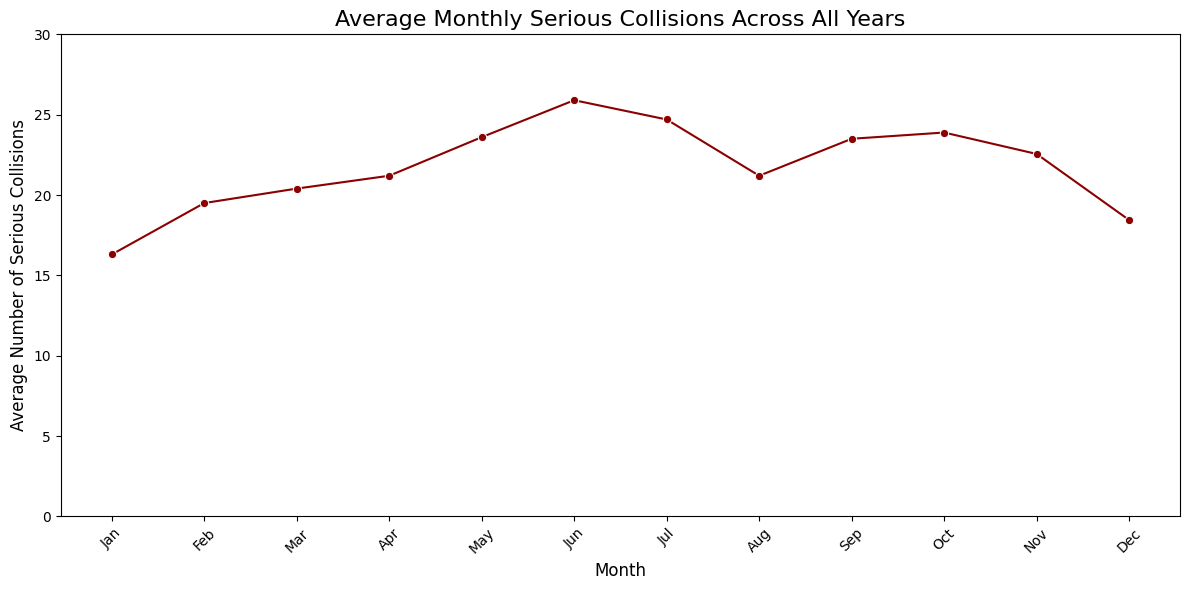

In [29]:
# Add month names for serious collisions
serious_collision_grouped_by_month['month_name'] = serious_collision_grouped_by_month['month'].astype(int).map(lambda x: calendar.month_abbr[x])

# Calculate the average number of serious collisions for each month
average_serious_collisions_by_month = serious_collision_grouped_by_month.groupby('month_name', as_index=False)['number_of_collisions'].mean()
average_serious_collisions_by_month['month_order'] = average_serious_collisions_by_month['month_name'].map(lambda x: list(calendar.month_abbr).index(x))
average_serious_collisions_by_month = average_serious_collisions_by_month.sort_values('month_order')

# Plot the average serious monthly collisions
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=average_serious_collisions_by_month, 
    x='month_name', 
    y='number_of_collisions', 
    marker='o', 
    color='darkred'
)
plt.title('Average Monthly Serious Collisions Across All Years', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Number of Serious Collisions', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 30)  # Adjust based on your data
plt.tight_layout()
plt.show()


In [30]:
num_of_serious_collisions_by_day = conn.sql("""
    SELECT 
        strftime(CAST(I.crash_datetime AS TIMESTAMP), '%w') AS weekday,
        COUNT(*) AS number_of_collisions
    FROM incidents I
    LEFT JOIN drivers D ON I.report_number = D.report_number
    LEFT JOIN non_motorist NM ON I.report_number = NM.report_number
    WHERE 
        (D.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
        OR NM.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY'))
    GROUP BY weekday
    ORDER BY weekday;
""").fetchdf()



num_of_serious_collisions_by_day['weekday_name'] = num_of_serious_collisions_by_day['weekday'].astype(int).map(lambda x: calendar.day_abbr[x])

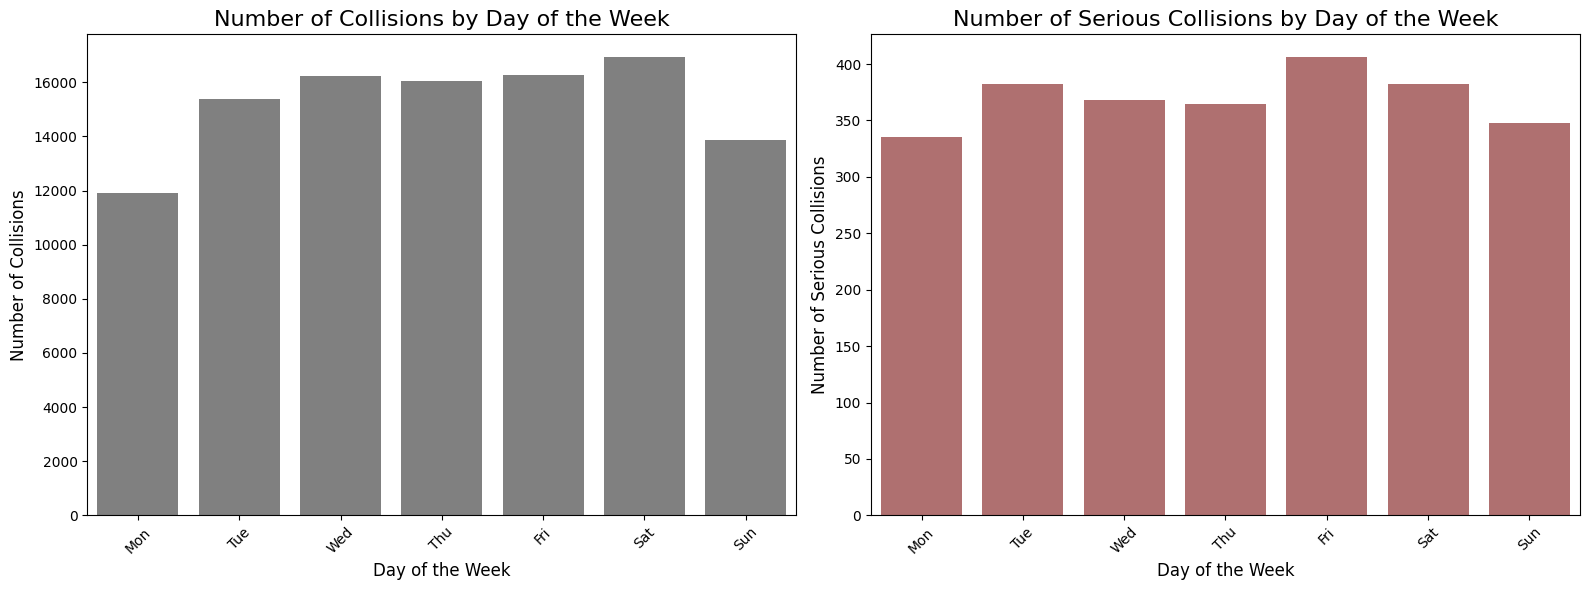

In [31]:
# Sort total collisions data by weekday
num_of_collisions_by_day['weekday_order'] = num_of_collisions_by_day['weekday_name'].map(lambda x: list(calendar.day_abbr).index(x))
num_of_collisions_by_day = num_of_collisions_by_day.sort_values('weekday_order')

# Sort serious collisions data by weekday
num_of_serious_collisions_by_day['weekday_name'] = num_of_serious_collisions_by_day['weekday'].astype(int).map(lambda x: calendar.day_abbr[x])
num_of_serious_collisions_by_day['weekday_order'] = num_of_serious_collisions_by_day['weekday_name'].map(lambda x: list(calendar.day_abbr).index(x))
num_of_serious_collisions_by_day = num_of_serious_collisions_by_day.sort_values('weekday_order')

# Create subplots for horizontal stacking with independent y-axes
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot total collisions
sns.barplot(
    data=num_of_collisions_by_day,
    x='weekday_name',
    y='number_of_collisions',
    color='gray',
    ax=axes[0]
)
axes[0].set_title('Number of Collisions by Day of the Week', fontsize=16)
axes[0].set_xlabel('Day of the Week', fontsize=12)
axes[0].set_ylabel('Number of Collisions', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot serious collisions
sns.barplot(
    data=num_of_serious_collisions_by_day,
    x='weekday_name',
    y='number_of_collisions',
    color='darkred',
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_title('Number of Serious Collisions by Day of the Week', fontsize=16)
axes[1].set_xlabel('Day of the Week', fontsize=12)
axes[1].set_ylabel('Number of Serious Collisions', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


#### Death Rate in Collisions (%)

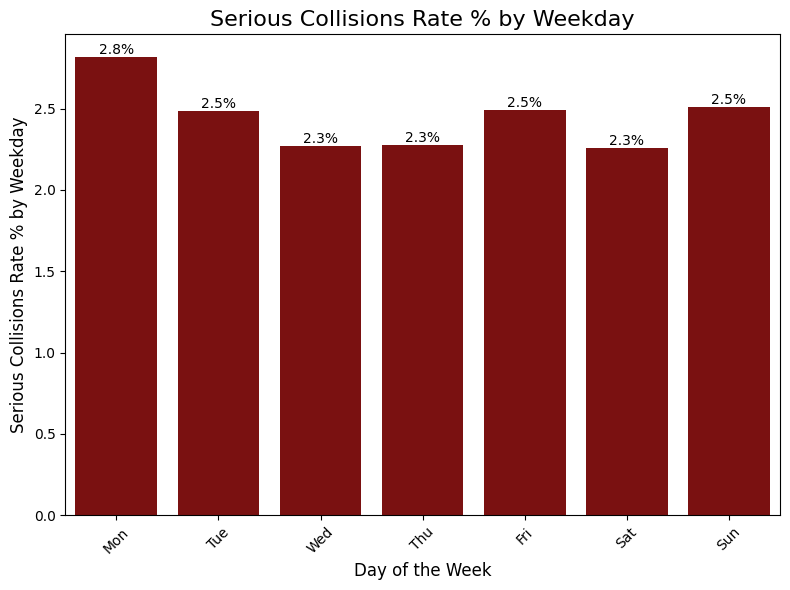

In [32]:
merged_collisions = pd.merge(
    num_of_collisions_by_day,
    num_of_serious_collisions_by_day,
    on='weekday_name',
    suffixes=('_total', '_serious')
)

merged_collisions["number_of_collisions_serious"] = merged_collisions["number_of_collisions_serious"].fillna(0)

# Compute the death rate
merged_collisions['death_rate'] = 100 * (
    merged_collisions['number_of_collisions_serious'] /
    merged_collisions['number_of_collisions_total']
)

# Sort by weekday order for proper plotting
weekday_order = list(calendar.day_abbr)  # ['Sun', 'Mon', 'Tue', ..., 'Sat']
merged_collisions['weekday_order'] = merged_collisions['weekday_name'].map(lambda x: weekday_order.index(x))
merged_collisions = merged_collisions.sort_values('weekday_order')

# Plot the death rate
# Plot the death rate
plt.figure(figsize=(8, 6))
barplot = sns.barplot(
    data=merged_collisions,
    x='weekday_name',
    y='death_rate',
    color='darkred',
    alpha=1
)

# Add percentage labels on top of each bar
for bar in barplot.patches:
    height = bar.get_height()
    barplot.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate
        height,  # Y-coordinate
        f'{height:.1f}%',  # Label text (percentage format)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Customize the plot
plt.title('Serious Collisions Rate % by Weekday', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Serious Collisions Rate % by Weekday', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [48]:
serious_collisions_rate_by_hour = conn.sql("""
WITH serious_collisions AS (
    SELECT 
        strftime(CAST(I.crash_datetime AS TIMESTAMP), '%H') AS hour,
        COUNT(*) AS serious_collisions
    FROM incidents I
    LEFT JOIN drivers D ON I.report_number = D.report_number
    LEFT JOIN non_motorist NM ON I.report_number = NM.report_number
    WHERE 
        D.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
        OR NM.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY')
    GROUP BY hour
),
total_collisions AS (
    SELECT 
        strftime(CAST(crash_datetime AS TIMESTAMP), '%H') AS hour,
        COUNT(*) AS total_collisions
    FROM incidents
    GROUP BY hour
)
SELECT 
    t.hour,
    t.total_collisions,
    COALESCE(s.serious_collisions, 0) AS serious_collisions,
    COALESCE(CAST(s.serious_collisions AS FLOAT), 0) / NULLIF(t.total_collisions, 0) AS serious_collision_rate
FROM total_collisions t
LEFT JOIN serious_collisions s
ON t.hour = s.hour
ORDER BY t.hour;
""").fetchdf()


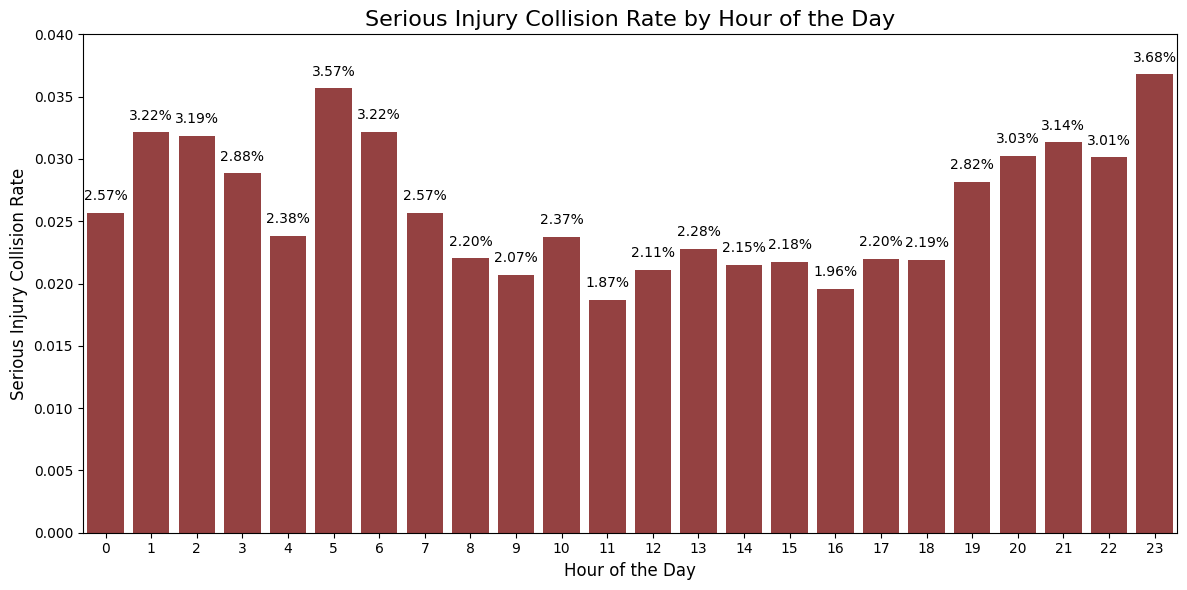

In [52]:
# Plot the barplot with percentages displayed on top of each bar
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=serious_collisions_rate_by_hour,
    x="hour",
    y="serious_collision_rate",
    color="darkred",
    alpha=0.8
)

# Add percentages on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2, 
        y=height + 0.001, 
        s=f"{height:.2%}",  # Convert to percentage
        ha="center", 
        fontsize=10
    )

# Add title and labels
plt.title("Serious Injury Collision Rate by Hour of the Day", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Serious Injury Collision Rate", fontsize=12)
plt.xticks(ticks=range(0, 24), labels=range(0, 24))  # Set hour ticks
plt.ylim(0, 0.04)
plt.tight_layout()
plt.show()


**Observation:**

- The barplot of serious collision rates by hour indicates that the frequency of serious injuries is not uniform across all hours of the day.
- The **highest rate** of serious injuries is observed during:
  - **11 PM - 12 AM**
  - **4 AM - 6 AM**
  - **12 AM - 1 AM**

- The **lowest rate** of serious injuries is observed during:
  - **10 AM - 11 AM**
  - **3 PM - 4 PM**
  - **8 AM - 9 AM**

**My explanation of observation (this is only a guess):**

- **High-Risk Hours (Highest Rates):**
  - **Late Night/Early Morning Fatigue:** Drivers may be more fatigued or drowsy during late-night hours (11 PM - 1 AM, 4 AM - 6 AM), leading to slower reaction times and higher risks of serious collisions.
  - **Alcohol Influence:** Late-night hours coincide with peak times for alcohol consumption, increasing the likelihood of impaired driving.
  - **Reduced Visibility:** Nighttime driving conditions offer reduced visibility, making it harder to detect and react to hazards.
  - **Lower Traffic Volumes:** Drivers might take more risks, such as speeding or reckless driving, during low-traffic hours at night.

- **Low-Risk Hours (Lowest Rates):**
  - **Daytime Visibility:** Daytime hours (8 AM - 9 AM, 10 AM - 11 AM, 3 PM - 4 PM) provide better visibility, allowing drivers to detect hazards more easily.
  - **Lower Speeds in Urban Areas:** Morning and afternoon hours often coincide with commuting times in urban areas, where traffic congestion may reduce vehicle speeds and the severity of collisions.
  - **Increased Alertness:** During these hours, drivers may be more alert as they are starting or midway through their day.


#### Hypotheses Testing for Multiple Groups

**explanation about ANOVA and Kruskal-Walis**

#### TEST: Number of total collisions is the same across different month in a year?


In [30]:
num_of_collisions_by_month = conn.sql("""
    SELECT 
    strftime(CAST(crash_datetime AS TIMESTAMP), '%Y') as year,
    strftime(CAST(crash_datetime AS TIMESTAMP), '%m') as month,
    COUNT(*) as collisions FROM incidents
    GROUP BY year, month ORDER BY year, month
    
""").fetchdf()

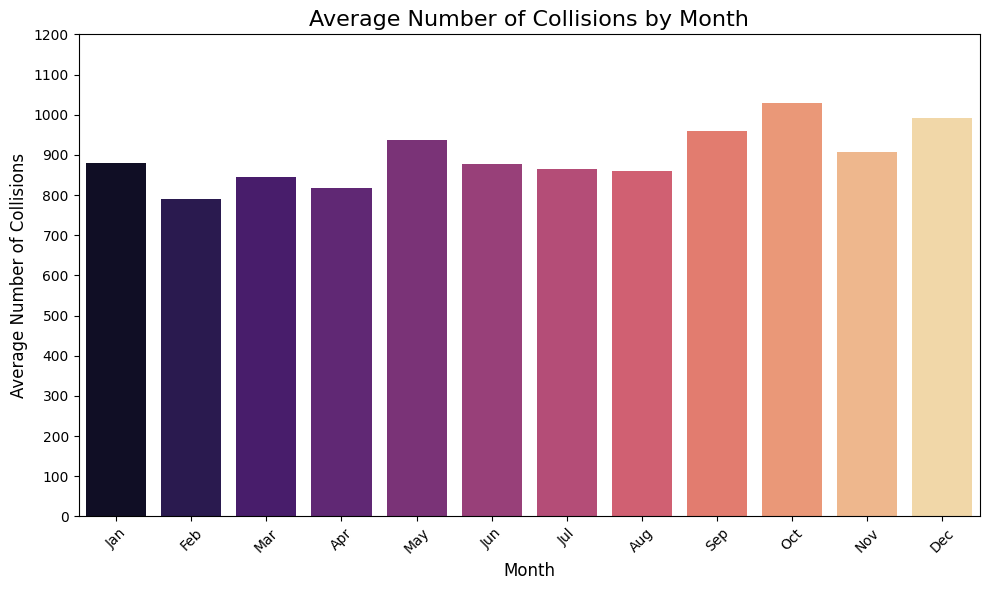

In [56]:
avg_collisions_by_month = num_of_collisions_by_month.groupby("month")["collisions"].mean().reset_index()
avg_collisions_by_month["month"] = avg_collisions_by_month["month"].astype(int)  # Ensure month is numeric
avg_collisions_by_month = avg_collisions_by_month.sort_values("month")  # Sort by month

# Plot barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_collisions_by_month, x="month", y="collisions", palette="magma")

plt.title("Average Number of Collisions by Month", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Number of Collisions", fontsize=12)
plt.xticks(ticks=range(12), labels=[calendar.month_abbr[i+1] for i in range(12)], rotation=45)
plt.yticks(np.arange(0, 1300, 100))
plt.tight_layout()
plt.show()


**Checking 1st Assumption for ANOVA: Normality**

Text(0, 0.5, 'Density')

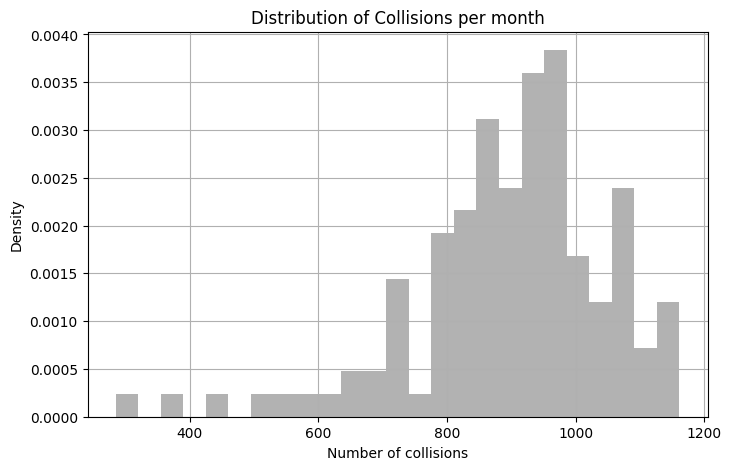

In [39]:

plt.figure(figsize=(8, 5))

num_of_collisions_by_month["collisions"].hist(bins=25, color="grey", alpha=0.6, density=True)
plt.title("Distribution of Collisions per month")
plt.xlabel("Number of collisions")
plt.ylabel("Density")

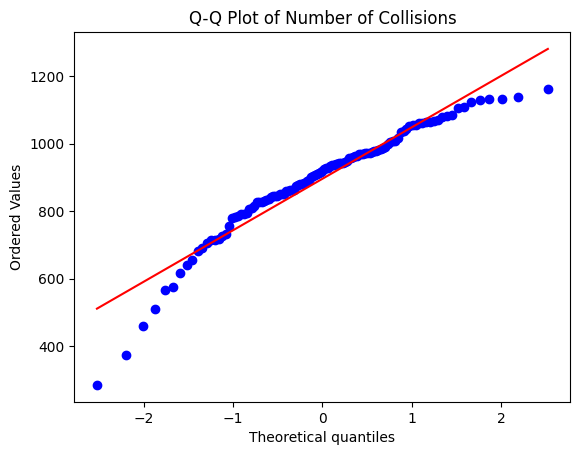

In [45]:
from scipy.stats import probplot

data = num_of_collisions_by_month["collisions"]
probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot of Number of Collisions')
plt.show()


Q-Q plot and Histogram tell us that *Number of Collisions* **does not have a Normal Distribution**. This means that 1st assumption for ANOVA **is not met** and we should use different test. We can use **Kruskal-Wallis nonparametric test** to test our hypotheses.


**Kruskal-Wallis test explanation**: https://datatab.net/tutorial/kruskal-wallis-test

**Hypotheses:**

    H0: The median number of collisions is the same across all months.
    H1: At least one month has a different median number of collisions 

**Significance level: 0.95**

In [47]:
from scipy.stats import kruskal

groups = [
    num_of_collisions_by_month[num_of_collisions_by_month['month'] == f"{i:02d}"]['collisions'].values
    for i in range(1, 13)
]
h_stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis H-statistic: {h_stat}")
print(f"P-value: {p_value}")



Kruskal-Wallis H-statistic: 35.17374375105093
P-value: 0.0002319671323742731


**Given P-value: << 0.05 from Kruskal-Wallis test, we have enough evidence to reject H0 hypotheses**. **Median number of collisions for each month is not the same**

#### TEST: Serious injury rate is the same across different month in a year?


In [81]:
serious_injury_rate_by_month = conn.sql("""
    WITH serious_collisions AS (
        SELECT 
            strftime(CAST(I.crash_datetime AS TIMESTAMP), '%Y-%m') AS month_year,
            strftime(CAST(I.crash_datetime AS TIMESTAMP), '%m') AS month,
            COUNT(*) AS serious_collisions
        FROM incidents I
        LEFT JOIN drivers D ON I.report_number = D.report_number
        LEFT JOIN non_motorist NM ON I.report_number = NM.report_number
        WHERE 
            (D.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
            OR NM.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY'))
        GROUP BY month_year, month
    ),
    total_collisions AS (
        SELECT 
            strftime(CAST(crash_datetime AS TIMESTAMP), '%Y-%m') AS month_year,
            strftime(CAST(crash_datetime AS TIMESTAMP), '%m') AS month,
            COUNT(*) AS total_collisions
        FROM incidents
        GROUP BY month_year, month
    )
    SELECT 
        t.month_year,
        t.month,
        t.total_collisions,
        s.serious_collisions,
        CAST(s.serious_collisions AS FLOAT) / NULLIF(t.total_collisions, 0) AS serious_injury_rate
    FROM total_collisions t
    LEFT JOIN serious_collisions s
    ON t.month_year = s.month_year
    ORDER BY t.month_year;
""").fetchdf()


**Checking 1st Assumption for ANOVA: Normality**

In order to determine what statistical test to use, we should see whether *Serious Injury Rate is Normally distributed*

Text(0, 0.5, 'Density')

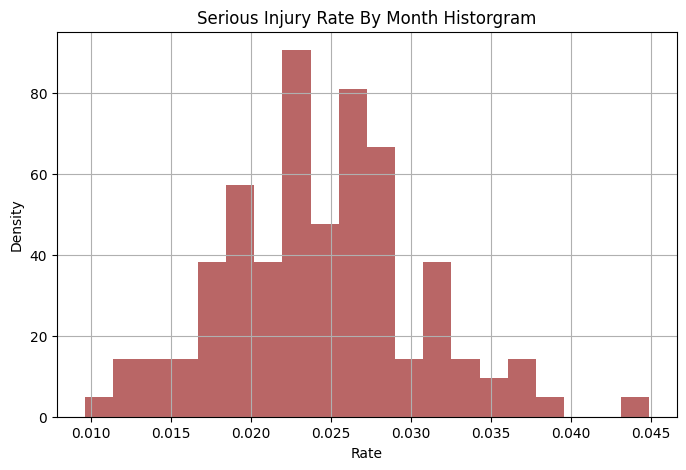

In [90]:

plt.figure(figsize=(8, 5))
serious_injury_rate_by_month["serious_injury_rate"].hist(bins=20, color="darkred", alpha=0.6, density=True)
plt.title("Serious Injury Rate By Month Historgram")
plt.xlabel("Rate")
plt.ylabel("Density")

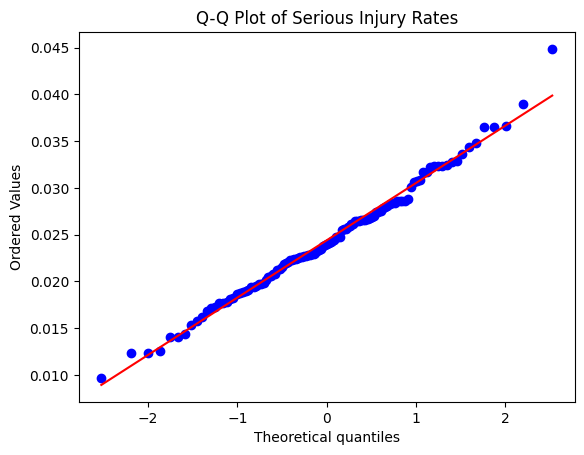

In [91]:


data = serious_injury_rate_by_month['serious_injury_rate']
probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot of Serious Injury Rates')
plt.show()

**Checking 2nd Assumption for ANOVA: Equal Variances across Groups**

In [104]:
serious_injury_rate_by_month.groupby("month")["serious_injury_rate"].var()

month
1     0.000045
2     0.000020
3     0.000029
4     0.000017
5     0.000030
6     0.000051
7     0.000028
8     0.000019
9     0.000031
10    0.000030
11    0.000045
12    0.000018
Name: serious_injury_rate, dtype: float32

We can clearly see that according to Q-Q plot diagnostics, our montly rates are roughly **normally distributed**. As for
second assumption, **all Variances are pretty close** to each other and looks like ANOVA assumptions are rather met.
That implies we can use **ANOVA** to test **hypotheses: whether serious injury rate is the same across different month in a year**. 


**Hypotheses:**

    H0: The mean serious injury rate is the same across all months.
    H1: At least one month has a different mean serious injury rate.

**Significance level: 0.95**

In [106]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

serious_injury_rate_by_month['month'] = serious_injury_rate_by_month['month'].astype(int)  # Ensure month is numeric

model = ols('serious_injury_rate ~ C(month)', data=serious_injury_rate_by_month).fit()
anova_table = sm.stats.anova_lm(model, typ=1)

In [107]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(month),11.0,0.001130,0.000103,3.395963,0.000463
Residual,107.0,0.003237,0.000030,NaN,NaN


In [108]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     serious_injury_rate   R-squared:                       0.259
Model:                             OLS   Adj. R-squared:                  0.183
Method:                  Least Squares   F-statistic:                     3.396
Date:                 Mon, 18 Nov 2024   Prob (F-statistic):           0.000463
Time:                         22:23:27   Log-Likelihood:                 456.62
No. Observations:                  119   AIC:                            -889.2
Df Residuals:                      107   BIC:                            -855.9
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0192      0.002     11.031      0.000       0.016       0.023
C(month)[T.2]      0.0053      0.002      2.166      0.033       0.000       0.010
C(month)[T.3]      0.0053      0.002      2.149      0.034       0.000       0.010
C(month)[T.4]      0.0065      0.002      2.632      0.010       0.002       0.011
C(month)[T.5]      0.0060      0.002      2.443      0.016       0.001       0.011
C(month)[T.6]      0.0105      0.002      4.270      0.000       0.006       0.015
C(month)[T.7]      0.0096      0.002      3.894      0.000       0.005       0.014
C(month)[T.8]      0.0056      0.002      2.283      0.024       0.001       0.010
C(month)[T.9]      0.0052      0.002      2.103      0.038       0.000       0.010
C(month)[T.10]     0.0053      0.002      2.144      0.034       0.000       0.010
C(month)[T.11]     0.0036      0.002      1.464      0.146      -0.001       0.008
C(month)[T.12]    -0.0009      0.003     -0.362      0.718      -0.006       0.004
==============================================================================
Omnibus:                        5.078   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                4.758
Skew:                           0.487   Prob(JB):                       0.0926
Kurtosis:                       3.105   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Takeaways

1. **Overall Model Significance**:
   - The model is statistically significant \( p < 0.001 \), indicating that the month has a significant effect on the serious injury rate.

2. **Significant Months**:
   - **June** shows the largest increase in serious injury rates compared to January, with a coefficient of **0.0105** \( p < 0.001 \).
   - **July** also has a high increase in serious injury rates, with a coefficient of **0.0096** \( p < 0.001 \).
   - **December** has a slight decrease compared to January, but this difference is not statistically significant \( p = 0.718 \).

**Hypotheses Test Conclusion: H0 is rejected. Data cannot confirm that injury rate is the same across different months**

#### Insights and Takeaways

**need to sum up this section on time-series patterns in collisions**

### Collision Circumstances Analysis


#### Related questions


This section aims to address the following questions:

1. **What is the main cause of driver distraction?**  
2. **What type of distraction appears to be the most dangerous?**  
3. **How do driverless vehicles compare to usual vehicles in terms of death rate and safety?**  
4. **What are the frequent patterns in fatal cases, and what are the most dangerous combinations of factors?**  
5. **What is the most common cause of collisions (first harmful event), and which is the most dangerous in terms of fatal and serious injury cases?**

By answering these questions, we aim to identify critical risk factors and uncover actionable insights to enhance road safety.  
